# MNIST image generation with VAE (Variational AutoEncoder)

Adapted from: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/11-VAE.ipynb

## Cell color
- Red: Related to model definition and training
- Skyblue: Related to visualization

### Required Python Packages
- `torch`
- `torchvision`
- `matplotlib`

Run the following cell to install the packages.

In [ ]:
# package install
!pip install "torch>=1.9+cpu"
!pip install "torchvision>=0.10.1+cpu"
!pip install "matplotlib>=3.5"

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Load the Dataset (MNIST)

In [2]:
# Define data loading step
kwargs = {"num_workers": 4, "pin_memory": True}
train_loader = DataLoader(
    datasets.MNIST("mnist", train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True,
    **kwargs,
)
test_loader = DataLoader(
    datasets.MNIST("mnist", train=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True,
    **kwargs,
)

/home/jovyan/.local/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


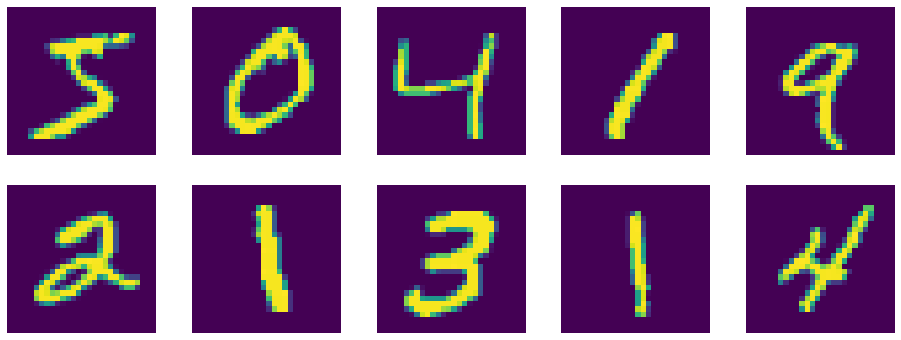

In [3]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis("off");

### Vanilla VAE

In [4]:
# Defining the model

d = 20


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(nn.Linear(784, d**2), nn.ReLU(), nn.Linear(d**2, d * 2))

        self.decoder = nn.Sequential(
            nn.Linear(d, d**2),
            nn.ReLU(),
            nn.Linear(d**2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_().detach()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

### Define loss function

In [5]:
# Reconstruction + β * KL divergence losses summed over all elements and batch


def loss_function(x_hat, x, mu, logvar, beta=1):
    BCE = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 784), reduction="sum")
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + beta * KLD

### Visualization function

### Training process

In [6]:
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(9, 2))
            plt.suptitle(label + " – real test data / reconstructions", color="b", fontsize=16)
            for i in range(4):
                plt.subplot(1, 4, i + 1)
                plt.imshow(in_pic[i + 4 * N])
                plt.axis("off")
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(9, 3))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.imshow(out_pic[i + 4 * N])
            plt.axis("off")
            if count:
                plt.title(str(4 * N + i), color="w")
    plt.show()

====> Test set loss: 543.7519


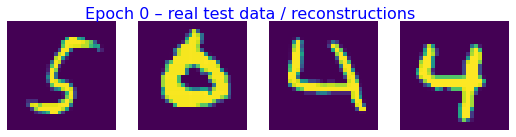

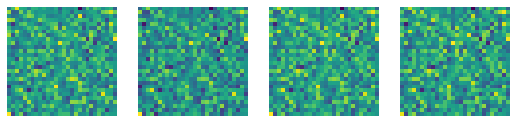

====> Epoch: 1 Average loss: 190.0560
====> Test set loss: 137.4955


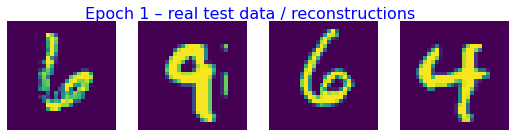

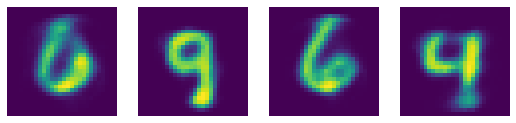

====> Epoch: 2 Average loss: 133.8396
====> Test set loss: 116.5032


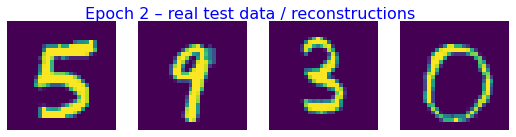

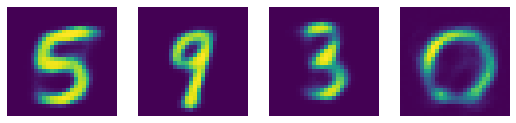

====> Epoch: 3 Average loss: 121.7237
====> Test set loss: 109.5354


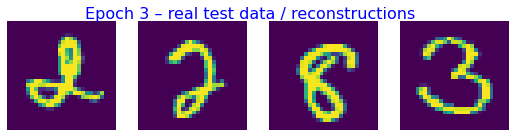

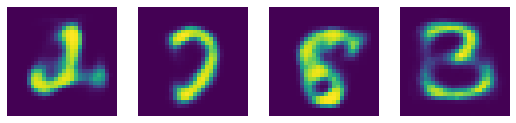

====> Epoch: 4 Average loss: 116.5905
====> Test set loss: 104.9082


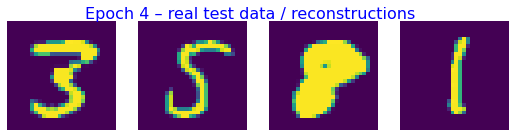

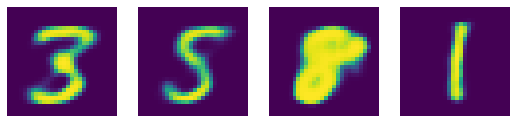

====> Epoch: 5 Average loss: 113.7427
====> Test set loss: 102.8385


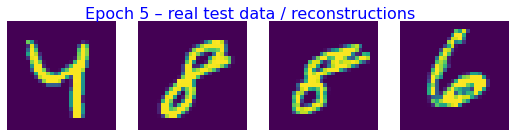

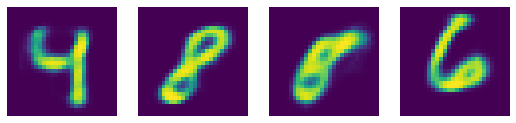

====> Epoch: 6 Average loss: 111.8959
====> Test set loss: 101.6415


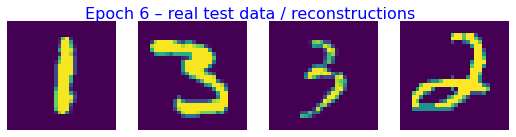

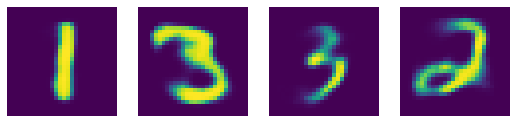

====> Epoch: 7 Average loss: 110.5948
====> Test set loss: 101.0912


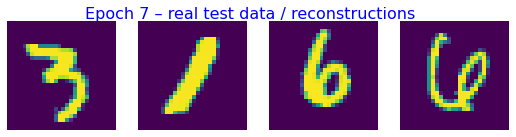

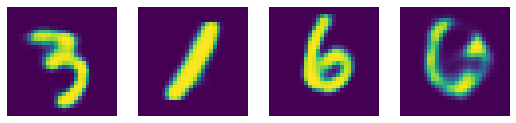

====> Epoch: 8 Average loss: 109.5482
====> Test set loss: 99.2361


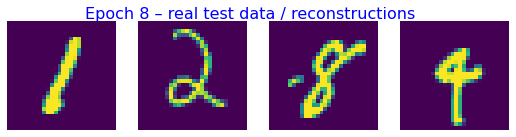

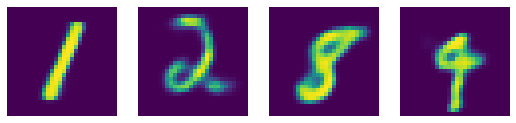

In [7]:
# Training and testing the VAE
codes = dict(mu=list(), logvar=list(), y=list())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)


def train_and_test(model):
    for epoch in range(0, epochs + 1):
        # Training
        if epoch > 0:  # test untrained net first
            model.train()
            train_loss = 0
            for x, _ in train_loader:
                x = x.to(device)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                loss = loss_function(x_hat, x, mu, logvar, beta)
                train_loss += loss.item()
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # ===================log========================
            print(f"====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}")

        # Testing
        means, logvars, labels = list(), list(), list()
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for x, y in test_loader:
                x = x.to(device)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                test_loss += loss_function(x_hat, x, mu, logvar, beta).item()
                # =====================log=======================
                means.append(mu.detach())
                logvars.append(logvar.detach())
                labels.append(y.detach())
        # ===================log========================
        codes["mu"].append(torch.cat(means))
        codes["logvar"].append(torch.cat(logvars))
        codes["y"].append(torch.cat(labels))
        test_loss /= len(test_loader.dataset)
        print(f"====> Test set loss: {test_loss:.4f}")
        display_images(x, x_hat, 1, f"Epoch {epoch}")


train_and_test(model)

### Generating few samples with randomly sampled vectors

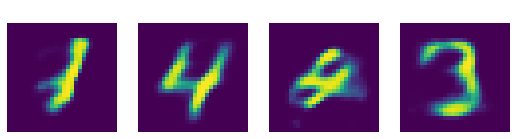

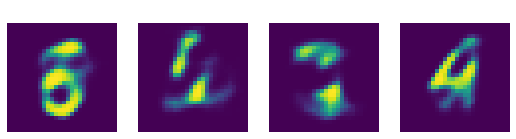

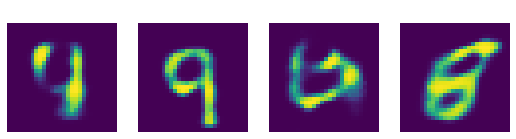

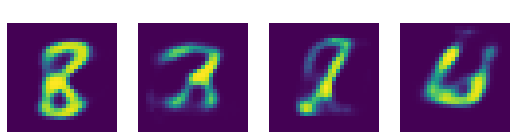

In [8]:
# Generating a few samples
N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

### Visualize with interpolation

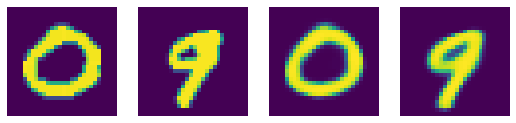

In [9]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed
x, _ = next(iter(train_loader))
_, mu, _ = model(x.to(device))
mu = mu.detach().requires_grad_(False)

A, B = 0, -1
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0)).detach()
display_images(None, torch.stack(((x[A].data.view(-1), x[B].data.view(-1), sample.data[0], sample.data[1])), 0))

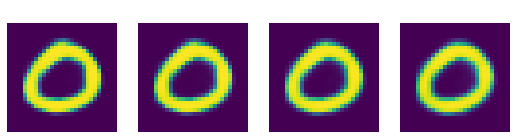

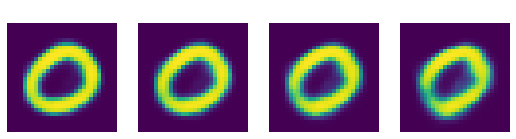

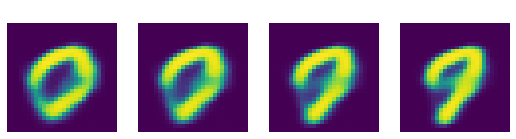

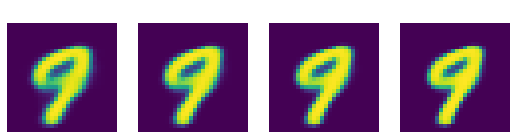

In [10]:
# Perform an interpolation between input A and B, in N steps
N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1)) * mu[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)